# Convolutional Neural Network in Pytorch

Welcome to this Jupyter notebook dedicated to Convolutional Neural Networks (CNNs). In the realm of deep learning, CNNs have emerged as a cornerstone in image processing, pattern recognition, and computer vision tasks.

## What Are CNNs and Why Do They Matter?

Convolutional Neural Networks are a specialized class of neural networks designed to recognize and extract hierarchical features from visual data. Unlike traditional neural networks, CNNs leverage convolutional layers to systematically scan and learn patterns, making them particularly adept at tasks like image classification, object detection, and facial recognition.

### Key Features of CNNs:

1. **Convolutional Layers:** These layers employ convolutional operations to detect spatial patterns, enabling the network to understand local relationships in the input data.

2. **Pooling Layers:** By downsampling and summarizing information, pooling layers help reduce computational complexity while preserving essential features.

3. **Fully Connected Layers:** At the end of the network, fully connected layers integrate the learned features to make final predictions.

---
# Import main libraries

In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm

import torch

import torch.nn as nn # Defines a series of classes to implement neural nets
import torch.nn.functional as F # Contains functions that are used in network layers

---

# MNIST Dataset

The MNIST dataset is a cornerstone in computer vision and deep learning, serving as a standard benchmark for image classification tasks. Developed by Yann LeCun, Corinna Cortes, and Christopher J.C. Burges, MNIST stands for *Modified National Institute of Standards and Technology*.

### What is MNIST?

MNIST consists of a vast collection of grayscale images, each depicting handwritten digits from 0 to 9. The dataset is widely used for training and testing various machine learning models, making it an ideal starting point for newcomers to the field.

### PyTorch and MNIST

Through PyTorch's torchvision module, accessing and manipulating MNIST becomes very straightforward. The torchvision.datasets module includes a pre-built MNIST class, simplifying the process of loading and handling the dataset.

### Key Characteristics:

- **Image Size:** Each image in MNIST is a 28x28 pixel grayscale image.
- **Training Set:** The dataset is split into a training set, used to train the model, and a test set for evaluating its performance.
- **Labeling:** Each image is associated with a corresponding label, indicating the digit it represents.

## Loading the dataset

In [13]:
import torch
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training and test datasets
train_dataset = datasets.MNIST('../Data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../Data', train=False, download=True, transform=transform)

In [14]:
print(f"Train dataset:\n{train_dataset}")
print(f"Test dataset:\n{test_dataset}")

Train dataset:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Test dataset:
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [15]:
from torch.utils.data import DataLoader

# train dataloader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=512,
                          shuffle=True)

# test dataloader
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=512,
                         shuffle=True)

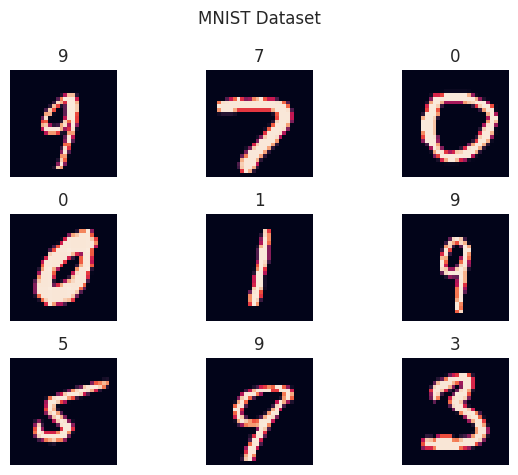

In [16]:
def show_batch(data, idx=0):
    
    fig, ax = plt.subplots(nrows=3, ncols=3)
    
    batch = next(iter(data))
    images, labels = batch[0], batch[1]

    for row in range(3):
        for column in range(3):
            ax[row, column].imshow(images[3*row + column][0, :, :])
            ax[row, column].axis('off')
            ax[row, column].set_title(int(labels[3*row+column]))
            
    plt.suptitle("MNIST Dataset")
    plt.tight_layout()
    plt.show()
    
show_batch(train_loader)

# Fully connected neural network

In this section, we explore the effects of omitting convolutional layers in neural network architectures for image classification. Despite the prevailing success of Convolutional Neural Networks (CNNs) in visual tasks, we investigate the viability of a network without these typical convolutional structures.

### Objective

We aim to assess the impact on classification accuracy when convolutional layers are excluded. This investigation provides insights into the essential role of convolutional layers in handling spatial relationships within images.

In [17]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.model = nn.Sequential(
            nn.Linear(784, 128)
            ,nn.ReLU()
            ,nn.Linear(128, 32)
            ,nn.ReLU()
            ,nn.Linear(32, 10)
        )
    
    def forward(self, x):
        
        return self.model(x)
        
        
    def train_model(self, dataloader, optimizer, loss_module, num_epochs=100, device='cpu'):
        
        self.train()
      
        for epoch in tqdm(range(num_epochs)):
            for images, labels in dataloader:
                
                # Step 1: Move images and labels to the device
                images = images.to(device)
                labels = labels.to(device)
                
                images  = images.view(images.size(0), -1)
                
                ## Step 2: Run the model
                predictions = self(images)
                predictions = predictions.squeeze(dim=1)  # Removing dimension 1

                ## Step 3: Computing the loss
                loss = loss_module(predictions, labels)  

                ## Step 4: Perform backpropagation
                optimizer.zero_grad()
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()
                

In [18]:
fc_model = FullyConnectedModel()

In [19]:
from torchinfo import summary

summary(model=fc_model, input_size=(1, 784), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
FullyConnectedModel (FullyConnectedModel)     [1, 784]             [1, 10]              --                   True
├─Sequential (model)                          [1, 784]             [1, 10]              --                   True
│    └─Linear (0)                             [1, 784]             [1, 128]             100,480              True
│    └─ReLU (1)                               [1, 128]             [1, 128]             --                   --
│    └─Linear (2)                             [1, 128]             [1, 32]              4,128                True
│    └─ReLU (3)                               [1, 32]              [1, 32]              --                   --
│    └─Linear (4)                             [1, 32]              [1, 10]              330                  True
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
Total mult-adds

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [21]:
fc_model.to(device)

FullyConnectedModel(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

## Training and Evaluating the model

In [22]:
# Implementing the loss module and the optimizer
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fc_model.parameters(), lr=0.01)

In [23]:
fc_model.train_model(dataloader=train_loader,
                     optimizer=optimizer,
                     loss_module=loss_module,
                     num_epochs=5,
                     device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Test loss:  0.63308 | Test acc:  0.84400


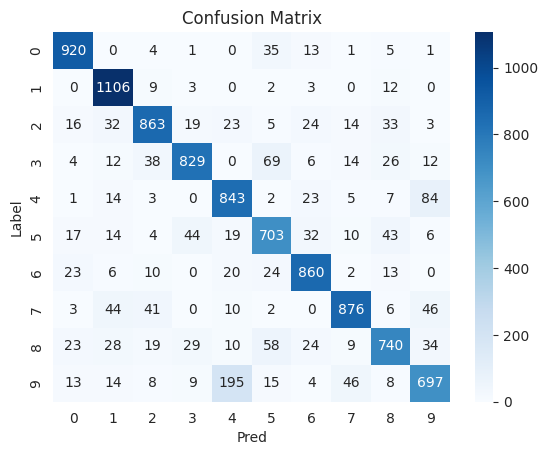

In [24]:
from torchmetrics import Accuracy

test_loss, test_acc = 0, 0

accuracy = Accuracy(task='multiclass', num_classes=10)
accuracy.to(device)

fc_model.eval()

preds, labels = [], []

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X  = X.view(X.size(0), -1) # Flatten the matrix
        y_pred = fc_model(X)
        
        test_loss += loss_module(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
        preds.extend(torch.argmax(y_pred.squeeze(dim=1), dim=1).squeeze(dim=0).cpu())
        labels.extend(y.cpu())
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    

print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .5f}")

sns.heatmap(confusion_matrix(labels, preds), annot=True, cmap='Blues', fmt='d').set_title("Confusion Matrix")
plt.xlabel("Pred")
plt.ylabel("Label")
plt.show()

## Convolutional Neural Network

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the modules of the neural network
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*32, 100) # 7x7 is the size of the image after the last conv layer
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        
        # Define the architecure
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1) # Flatten the tensor
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x
    
    def train_model(self, dataloader, optimizer, loss_module, num_epochs=100, device='cpu'):
        
        self.train()
      
        for epoch in tqdm(range(num_epochs)):
            for images, labels in dataloader:
                
                # Step 1: Move images and labels to the device
                images = images.to(device)
                labels = labels.to(device)
                                
                ## Step 2: Run the model
                predictions = self(images)
                predictions = predictions.squeeze(dim=1)  # Removing dimension 1

                ## Step 3: Computing the loss
                loss = loss_module(predictions, labels)  

                ## Step 4: Perform backpropagation
                optimizer.zero_grad()
                loss.backward()

                ## Step 5: Update the parameters
                optimizer.step()


In [27]:
cnn_model = CNN()

In [11]:
summary(model=cnn_model, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNN (CNN)                                [1, 1, 28, 28]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 1, 28, 28]       [1, 16, 28, 28]      160                  True
├─ReLU (relu)                            [1, 16, 28, 28]      [1, 16, 28, 28]      --                   --
├─MaxPool2d (maxpool)                    [1, 16, 28, 28]      [1, 16, 14, 14]      --                   --
├─Conv2d (conv2)                         [1, 16, 14, 14]      [1, 32, 14, 14]      4,640                True
├─ReLU (relu)                            [1, 32, 14, 14]      [1, 32, 14, 14]      --                   --
├─MaxPool2d (maxpool)                    [1, 32, 14, 14]      [1, 32, 7, 7]        --                   --
├─Linear (fc1)                           [1, 1568]            [1, 100]             156,900              True
├─ReLU (relu)         

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [29]:
# Implementing the loss module and the optimizer
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.1)

In [30]:
cnn_model.train_model(dataloader=train_loader,
                                     optimizer=optimizer,
                                     loss_module=loss_module,
                                     num_epochs=5,
                                     device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Test loss:  0.09911 | Test acc:  0.96854


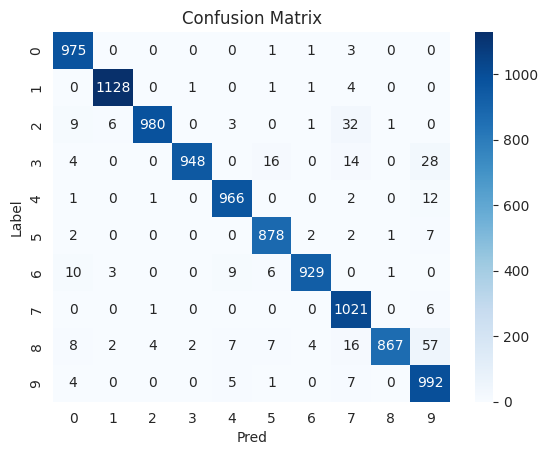

In [31]:
test_loss, test_acc = 0, 0

accuracy = Accuracy(task='multiclass', num_classes=10)
accuracy.to(device)

fc_model.eval()

preds, labels = [], []

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = cnn_model(X)
        
        test_loss += loss_module(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
        preds.extend(torch.argmax(y_pred.squeeze(dim=1), dim=1).squeeze(dim=0).cpu())
        labels.extend(y.cpu())
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    

print(f"Test loss: {test_loss: .5f} | Test acc: {test_acc: .5f}")

sns.heatmap(confusion_matrix(labels, preds), annot=True, cmap='Blues', fmt='d').set_title("Confusion Matrix")
plt.xlabel("Pred")
plt.ylabel("Label")
plt.show()

In [32]:
def get_activations(model, dataset, device):

    model.eval()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    
    layer_activations = []
    
    def get_layer_activation():
        def hook(model, input, output):
            layer_activations.append(output.squeeze(0))
        return hook
    
    # Collega la funzione hook agli strati intermedi della tua rete
    model.fc1.register_forward_hook(get_layer_activation())

    labels = []
    counter = 0
    
    with torch.no_grad():
        for img, label in tqdm(dataloader):
            img=img.to(device)
            

            # Inoltra l'immagine attraverso la rete
            output = model(img)
            labels.append(label)
            
            if counter  == len(dataloader) + 1:
                break
            
            counter += 1
        
        return layer_activations, labels


In [33]:
activations, labels = get_activations(cnn_model, test_dataset, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
from sklearn.manifold import TSNE

In [35]:
activations = [act.cpu().numpy() for act in activations]
labels = [lab[0].cpu().numpy() for lab in labels]

In [36]:
activation_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=8,verbose=3).fit_transform(np.array(activations))

[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.601s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.035654
[t-SNE] Computed conditional probabilities in 0.125s
[t-SNE] Iteration 50: error = 113.0239792, gradient norm = 0.0057234 (50 iterations in 6.040s)
[t-SNE] I

In [ ]:
# !pip install plotly==4.9.0
# !pip install jupyterlab "ipywidgets>=7.5"
#!jupyter labextension install jupyterlab-plotly

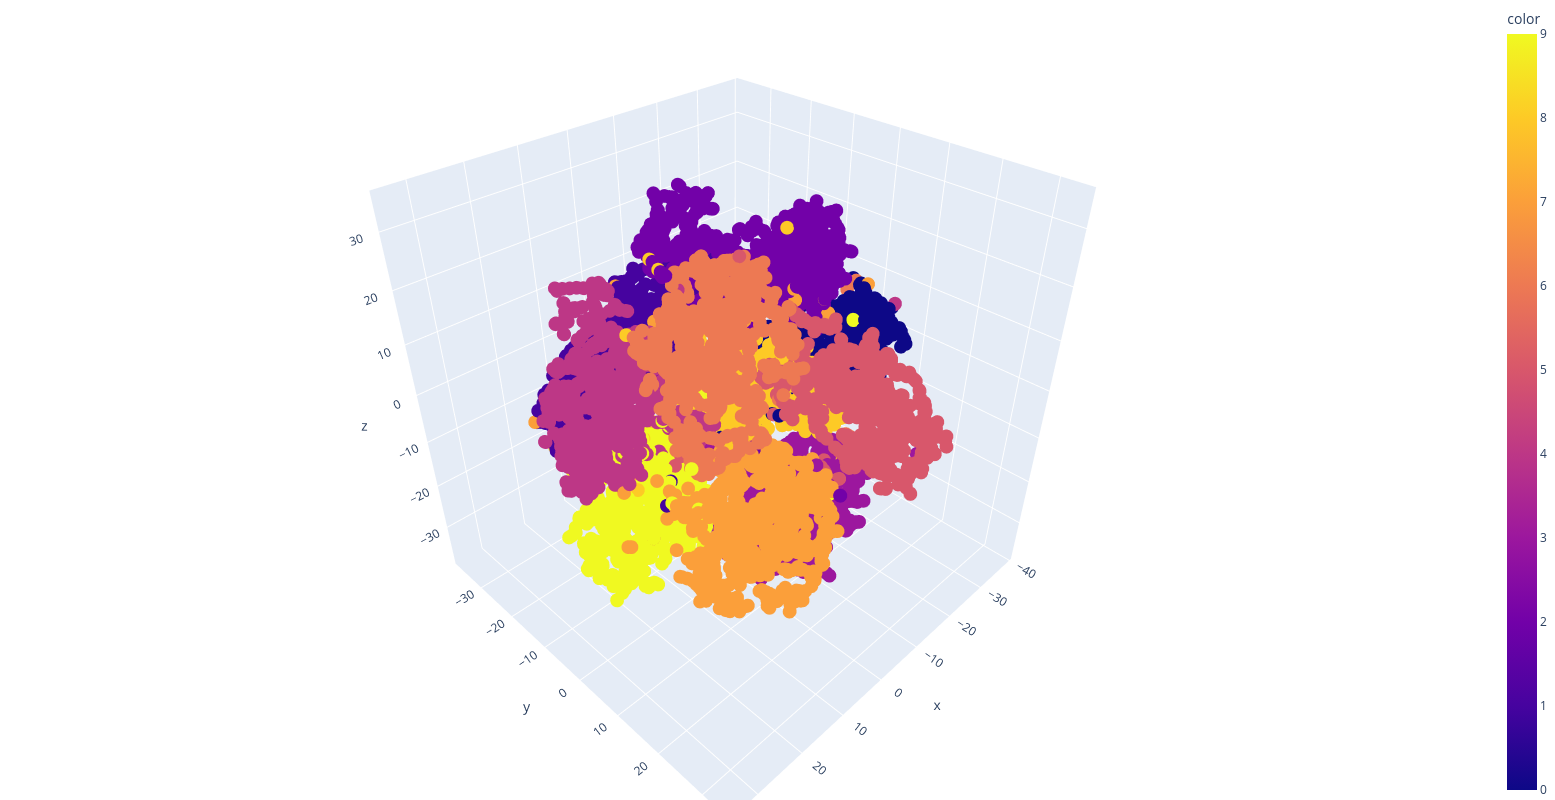

In [38]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

fig = px.scatter_3d(x=activation_embedded[:,0], y=activation_embedded[:,1], z=activation_embedded[:,2], color=labels)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), width=1500, height=800)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.show()
